# L1: Automated Project: Planning, Estimation, and Allocation

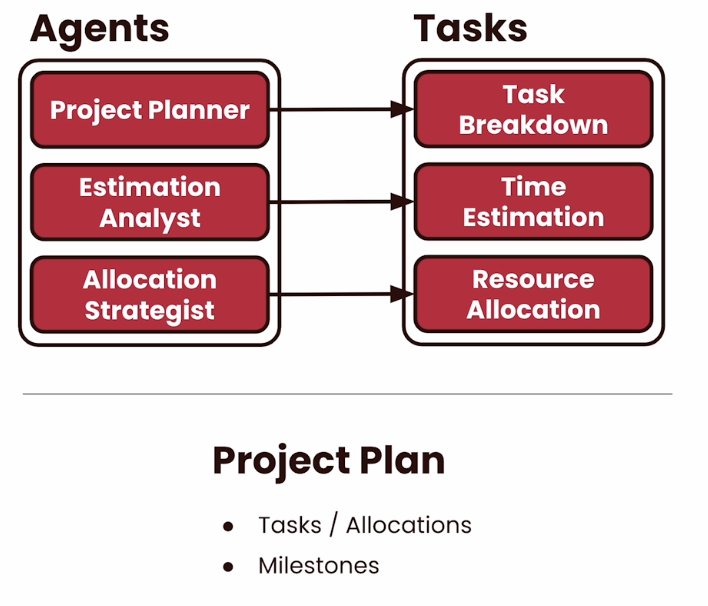

## Initial Imports

In [2]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

# Load environment variables
from helper import load_env
load_env()

import os
import yaml
from crewai import Agent, Task, Crew

ModuleNotFoundError: No module named 'helper'

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>

## Set OpenAI Model

In [ ]:
os.environ['OPENAI_MODEL_NAME'] = 'gpt-4o-mini'

## Loading Tasks and Agents YAML files

In [ ]:
# Define file paths for YAML configurations
files = {
    'agents': 'config/agents.yaml',
    'tasks': 'config/tasks.yaml'
}

# Load configurations from YAML files
configs = {}
for config_type, file_path in files.items():
    with open(file_path, 'r') as file:
        configs[config_type] = yaml.safe_load(file)

# Assign loaded configurations to specific variables
agents_config = configs['agents']
tasks_config = configs['tasks']

## Create Pydantic Models for Structured Output

In [ ]:
from typing import List
from pydantic import BaseModel, Field

class TaskEstimate(BaseModel):
    task_name: str = Field(..., description="Name of the task")
    estimated_time_hours: float = Field(..., description="Estimated time to complete the task in hours")
    required_resources: List[str] = Field(..., description="List of resources required to complete the task")

class Milestone(BaseModel):
    milestone_name: str = Field(..., description="Name of the milestone")
    tasks: List[str] = Field(..., description="List of task IDs associated with this milestone")

class ProjectPlan(BaseModel):
    tasks: List[TaskEstimate] = Field(..., description="List of tasks with their estimates")
    milestones: List[Milestone] = Field(..., description="List of project milestones")

## Create Crew, Agents and Tasks

In [ ]:
# Creating Agents
project_planning_agent = Agent(
  config=agents_config['project_planning_agent']
)

estimation_agent = Agent(
  config=agents_config['estimation_agent']
)

resource_allocation_agent = Agent(
  config=agents_config['resource_allocation_agent']
)

# Creating Tasks
task_breakdown = Task(
  config=tasks_config['task_breakdown'],
  agent=project_planning_agent
)

time_resource_estimation = Task(
  config=tasks_config['time_resource_estimation'],
  agent=estimation_agent
)

resource_allocation = Task(
  config=tasks_config['resource_allocation'],
  agent=resource_allocation_agent,
  output_pydantic=ProjectPlan # This is the structured output we want
)

# Creating Crew
crew = Crew(
  agents=[
    project_planning_agent,
    estimation_agent,
    resource_allocation_agent
  ],
  tasks=[
    task_breakdown,
    time_resource_estimation,
    resource_allocation
  ],
  verbose=True
)

## Crew's Inputs

In [ ]:
from IPython.display import display, Markdown

project = 'Website'
industry = 'Technology'
project_objectives = 'Create a website for a small business'
team_members = """
- John Doe (Project Manager)
- Jane Doe (Software Engineer)
- Bob Smith (Designer)
- Alice Johnson (QA Engineer)
- Tom Brown (QA Engineer)
"""
project_requirements = """
- Create a responsive design that works well on desktop and mobile devices
- Implement a modern, visually appealing user interface with a clean look
- Develop a user-friendly navigation system with intuitive menu structure
- Include an "About Us" page highlighting the company's history and values
- Design a "Services" page showcasing the business's offerings with descriptions
- Create a "Contact Us" page with a form and integrated map for communication
- Implement a blog section for sharing industry news and company updates
- Ensure fast loading times and optimize for search engines (SEO)
- Integrate social media links and sharing capabilities
- Include a testimonials section to showcase customer feedback and build trust
"""

# Format the dictionary as Markdown for a better display in Jupyter Lab
formatted_output = f"""
**Project Type:** {project}

**Project Objectives:** {project_objectives}

**Industry:** {industry}

**Team Members:**
{team_members}
**Project Requirements:**
{project_requirements}
"""
# Display the formatted output as Markdown
display(Markdown(formatted_output))

## Kicking off the crew

In [ ]:
# The given Python dictionary
inputs = {
  'project_type': project,
  'project_objectives': project_objectives,
  'industry': industry,
  'team_members': team_members,
  'project_requirements': project_requirements
}

# Run the crew
result = crew.kickoff(
  inputs=inputs
)

## Usage Metrics and Costs

Let’s see how much it would cost each time if this crew runs at scale.

In [ ]:
import pandas as pd

costs = 0.150 * (crew.usage_metrics.prompt_tokens + crew.usage_metrics.completion_tokens) / 1_000_000
print(f"Total costs: ${costs:.4f}")

# Convert UsageMetrics instance to a DataFrame
df_usage_metrics = pd.DataFrame([crew.usage_metrics.dict()])
df_usage_metrics

## Result

In [ ]:
result.pydantic.dict()

## Inspect further

In [ ]:
tasks = result.pydantic.dict()['tasks']
df_tasks = pd.DataFrame(tasks)

# Display the DataFrame as an HTML table
df_tasks.style.set_table_attributes('border="1"').set_caption("Task Details").set_table_styles(
    [{'selector': 'th, td', 'props': [('font-size', '120%')]}]
)

### Inspecting Milestones

In [ ]:
milestones = result.pydantic.dict()['milestones']
df_milestones = pd.DataFrame(milestones)

# Display the DataFrame as an HTML table
df_milestones.style.set_table_attributes('border="1"').set_caption("Task Details").set_table_styles(
    [{'selector': 'th, td', 'props': [('font-size', '120%')]}]
)